<a href="https://colab.research.google.com/github/gfgullo/ImageCaptioning/blob/master/image_captioning_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Keras

## Dependencies

In [0]:
import numpy as np

import json
import string
import pickle
from os import listdir
from time import time
from random import randint

from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

from keras.layers import Input, Dropout, Embedding, LSTM, Dense
from keras.layers.merge import add

from keras.callbacks import LambdaCallback

from nltk.translate.bleu_score import corpus_bleu

from IPython.display import display

## Get the Data

In [1]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip
  
!unzip annotations_trainval2014.zip
!unzip train2014.zip

--2019-08-25 08:59:11--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.38.228
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.38.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  48.2MB/s    in 5.4s    

2019-08-25 08:59:17 (44.6 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

--2019-08-25 08:59:20--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.160.227
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.160.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  46.0MB/

## Preprocess the Text

In [125]:
MAX_SAMPLES = 30000 

CAPTIONS_FILE = "annotations/captions_train2014.json"

captions_text = []
captions_img = []

with open(CAPTIONS_FILE) as captions_file:
  
  captions_json = json.loads(captions_file.read())
  
  for caption in captions_json["annotations"]:
        
    caption_text = caption["caption"]
    
    caption_text = caption_text.lower()
    caption_text = caption_text.translate(str.maketrans('', '', string.punctuation))
    caption_text = "startseq "+caption_text+" endseq"
    
    captions_text.append(caption_text)
      
    caption_img = 'COCO_train2014_' + '%012d.jpg' % (caption["image_id"])
    captions_img.append(caption_img)    
    

captions_img, captions_text = shuffle(captions_img, captions_text)

if(MAX_SAMPLES!=None):
  captions_img = captions_img[:MAX_SAMPLES]
  captions_text = captions_text[:MAX_SAMPLES]
    
len(captions_img)

30000

## Load the Encoder

In [3]:
HEIGHT = 299
WIDTH = 299
OUTPUT_DIM = 2048

encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)

Using TensorFlow backend.
W0825 09:28:30.891484 140640901949312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 09:28:30.917113 140640901949312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 09:28:30.927462 140640901949312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 09:28:30.963091 140640901949312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0825 

96116736/96112376 [==============================] - 3s 0us/step


## Preprocess the Images...

In [128]:
IMG_PATH = "train2014/"

imgs_name = set(captions_img)
encoded_imgs = {}

start = time()

for i, img_name in enumerate(imgs_name):
  
  img = load_img(IMG_PATH+img_name)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)  
  arr = img_to_array(img)
  
  x = preprocess_input(arr)
  x = np.expand_dims(x, axis=0)
    
  features = encode_model.predict(x)
  features = np.reshape(features, OUTPUT_DIM)

  encoded_imgs[img_name]=features
  
  if(i%25000==0):
    with open("features.pkl","wb") as handle:
      pickle.dump(encoded_imgs ,handle)

      
with open("features.pkl","wb") as handle:
  pickle.dump(encoded_imgs ,handle)      

  
print(len(imgs_name))
print(round(time()-start, 2))

25938
1417.57


## ... or load the preprocessed features

In [127]:
with open("features","rb") as handle:
  encoded_imgs = pickle.load(handle)
  
len(encoded_imgs)

1

## Create the Train, Test and Validation Set

In [130]:
captions_text_train, captions_text_test, captions_img_train, captions_img_test = train_test_split(captions_text, captions_img, test_size=0.05, random_state=0)

print("Sample in Train Set: %d " % len(captions_text_train))
print("Sample in Test Set: %d " % len(captions_text_test))

Sample in Train Set: 28500 
Sample in Test Set: 1500 
Sample in Validation Set: 3000 


## Create the Tokenizer

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(captions_text)

sequences_train = tokenizer.texts_to_sequences(captions_text_train)
sequences_test = tokenizer.texts_to_sequences(captions_text_test)

In [132]:
VOCAB_SIZE = len(tokenizer.word_index)+1
MAX_LEN = max(len(text.split()) for text in captions_text)

print(VOCAB_SIZE)
print(MAX_LEN)

8134
47


## OPTION 1: Load everything in Memory

In [0]:
def create_sequence(sequences, captions_img, max_length, vocab_size):
  
  X1, X2, Y = [], [], []

  for seq, caption_img in zip(sequences, captions_img):

    
    for i in range(len(seq)-1):
      X1.append(encoded_imgs[caption_img])
      X2.append(pad_sequences([seq[:i+1]], maxlen=max_length)[0])
      Y.append(to_categorical([seq[i+1]], num_classes=vocab_size)[0])
      
  return np.array(X1), np.array(X2), np.array(Y)


X1_train, X2_train, Y_train = create_sequence(sequences_train, captions_img_train, MAX_LEN, VOCAB_SIZE)
X1_test, X2_test, Y_test = create_sequence(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE)

## OPTION 2: Use a Generator

In [133]:
def create_sequence(seq, caption_img, max_length, vocab_size):
  
  x1, x2, y = [], [], []

    
  for i in range(len(seq)-1):
    x1.append(encoded_imgs[caption_img])
    x2.append(pad_sequences([seq[:i+1]], maxlen=max_length)[0])
    y.append(to_categorical([seq[i+1]], num_classes=vocab_size)[0])
      
  return x1, x2, y


def data_generator(sequences, captions_img, max_length, vocab_size, batch_size=None):
 
  tot_samples = len(captions_text)
  
  if(batch_size==None):
    batch_size=tot_samples
  
  n_batches = int(tot_samples/batch_size)
  
  while 1:
    
    batch_start = 0
    
    for _ in range(n_batches):
            
      X1, X2, Y = [], [], [] 
      
      batch_end = batch_start+batch_size
            
      if(batch_end>tot_samples):
        batch_end = tot_samples
        
      sequences_batch = sequences[batch_start:batch_end] 
      captions_img_batch = captions_img[batch_start:batch_end]     
                
      for seq, caption_img in zip(sequences_batch, captions_img_batch):
        
        x1, x2, y = create_sequence(seq, caption_img, max_length, vocab_size)
        
        if(len(X1)==0):
          X1, X2, Y = x1, x2, y
        else:
          X1, X2, Y = X1+x1, X2+x2, Y+y

      batch_start+=batch_size
        
      yield [[np.array(X1), np.array(X2)],np.array(Y)]      
    
    

"""
start_at = time()

for i in range(100):
  X, Y = data_batch_generator(tokenizer, captions_text_train, captions_img_train, MAX_LEN, VOCAB_SIZE, batch_size=1)
  X1, X2 = X
  
print(time()-start_at)
"""

'\nstart_at = time()\n\nfor i in range(100):\n  X, Y = data_batch_generator(tokenizer, captions_text_train, captions_img_train, MAX_LEN, VOCAB_SIZE, batch_size=1)\n  X1, X2 = X\n  \nprint(time()-start_at)\n'

## Create the Embedding

In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip  

--2019-08-25 10:24:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-25 10:24:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-25 10:24:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
def load_embedding(filename):
  
  with open(filename) as file:
    lines = file.readlines()

  embedding = dict()
  
  for line in lines:
    parts = line.split()
    embedding[parts[0]] = np.asarray(parts[1:])
    
  return embedding

raw_embedding = load_embedding('glove.6B.100d.txt')

In [135]:
def get_weight_matrix(embedding, word_index):
  
  vocab_size = len(word_index)+1
  
  weight_matrix = np.zeros((vocab_size, 100))

  for word, i in word_index.items():
    vector = embedding.get(word)
    if vector is not None:
      weight_matrix[i] = vector
      
  return weight_matrix

embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
embedding_vectors.shape

(8134, 100)

## Load the Neural Network...

In [21]:
caption_model = load_model("caption_model.h5")

OSError: ignored

##... or build it

In [0]:
EMBEDDING_DIM = 100
BATCH_SIZE = 64

In [0]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, weights=[embedding_vectors], trainable=False)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [0]:
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Define a function to generate captions taking the encoded image

In [0]:
def generate_caption(x1):
  
  caption = "startseq"
          
  for i in range(MAX_LEN):
    
    seq = tokenizer.texts_to_sequences([caption])
    x2 = pad_sequences(seq, maxlen=MAX_LEN)
        
    y = caption_model.predict([x1,x2], verbose=0)
    word = tokenizer.index_word[np.argmax(y)]
        
    caption+=" "+word
    
    if word == "endseq":
      break

  return caption

## OPTION 1: Fit on the Train Set and Evaluate on the Test Set

In [0]:
def generate_on_epoch(epoch, _):
  test_sample = randint(0, len(captions_text_test))
  x1 = encoded_imgs[captions_img_test[test_sample]]
  x1 = np.expand_dims(x1, axis=0)
  
  print("GENERATED CAPTION: "+generate_caption(x1))
  print("TRUE CAPTION: "+captions_text_test[test_sample])

In [96]:
epoch_end_callback = LambdaCallback(on_epoch_end=generate_on_epoch)
caption_model.fit([X1_train, X2_train], Y_train, batch_size=64, epochs=10, callbacks=[epoch_end_callback])

Epoch 1/10
108504/108504 [==============================] - 246s 2ms/step - loss: 4.5810
GENERATED CAPTION: startseq a man sitting on a table with a table endseq
TRUE CAPTION: startseq a woman wearing a blue curly wig talking on a phone endseq
Epoch 2/10
108504/108504 [==============================] - 245s 2ms/step - loss: 3.7473
GENERATED CAPTION: startseq a man is riding a street in a street endseq
TRUE CAPTION: startseq taxi cabs are driving down a wet city street  endseq
Epoch 3/10
108504/108504 [==============================] - 242s 2ms/step - loss: 3.3929
GENERATED CAPTION: startseq a person flying a kite in the ocean endseq
TRUE CAPTION: startseq a plane pulling a banner over the top of a beach endseq
Epoch 4/10
108504/108504 [==============================] - 242s 2ms/step - loss: 3.1651
GENERATED CAPTION: startseq a man is sitting on a table with a laptop endseq
TRUE CAPTION: startseq a picture of ships out on rough open waters endseq
Epoch 5/10
108504/108504 [==============

In [107]:
caption_model.evaluate([X1_test, X2_test], Y_test)

(108504, 2048)
5721/5721 [==============================] - 10s 2ms/step


3.7415646812211922

## OPTION 2: Fit and Evaluate with Generators

In [0]:
def train_step(batch_size):

  generator_train = data_generator(sequences_train, captions_img_train, MAX_LEN, VOCAB_SIZE, batch_size=batch_size)
  generator_val = data_generator(sequences_val, captions_img_val, MAX_LEN, VOCAB_SIZE, batch_size=batch_size)

  caption_model.fit_generator(generator_train, epochs=1, steps_per_epoch=len(captions_text_train)//batch_size, validation_data=generator_val, validation_steps=len(captions_text_val)//batch_size)
  caption_model.save("caption_model.h5")
  
  test_sample = randint(0, len(captions_text_test))

  x1 = encoded_imgs[captions_img_test[test_sample]]
  x1 = np.expand_dims(x1, axis=0)

  print("GENERATED CAPTION: "+generate_caption(x1))
  print("TRUE CAPTION: "+captions_text_test[test_sample])

In [123]:
for _ in range(20):
  train_step(3)
caption_model.optimizer.lr = 1e-4
for _ in range(10):
  train_step(6)

Epoch 1/1


TypeError: ignored

In [98]:
generator_test = data_generator(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE, batch_size=1)
caption_model.evaluate_generator(generator_test, steps=len(sequences_test))

TypeError: ignored

## Evaluate with the BLEU Score

In [110]:
generated_captions = []

for caption, img_name in zip(captions_text_test, captions_img_test):
  x1 = encoded_imgs[img_name]
  x1 = np.expand_dims(x1, axis=0)
  generated_captions.append(generate_caption(x1))
  
print('BLEU-1: %f' % corpus_bleu(captions_text_test, generated_captions, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(captions_text_test, generated_captions, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(captions_text_test, generated_captions, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(captions_text_test, generated_captions, weights=(0.25, 0.25, 0.25, 0.25)))  

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.256568
BLEU-2: 0.506525
BLEU-3: 0.664906
BLEU-4: 0.711706


## Test the Neural Network

In [115]:
!wget https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_960_720.jpg

--2019-08-25 16:22:23--  http://onebigphoto.com/uploads/2011/12/ibiza-beach-girl.jpg
Resolving onebigphoto.com (onebigphoto.com)... 209.222.18.3
Connecting to onebigphoto.com (onebigphoto.com)|209.222.18.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240550 (235K) [image/jpeg]
Saving to: ‘ibiza-beach-girl.jpg’

ibiza-beach-girl.jp 100%[===================>] 234.91K   940KB/s    in 0.2s    

2019-08-25 16:22:23 (940 KB/s) - ‘ibiza-beach-girl.jpg’ saved [240550/240550]



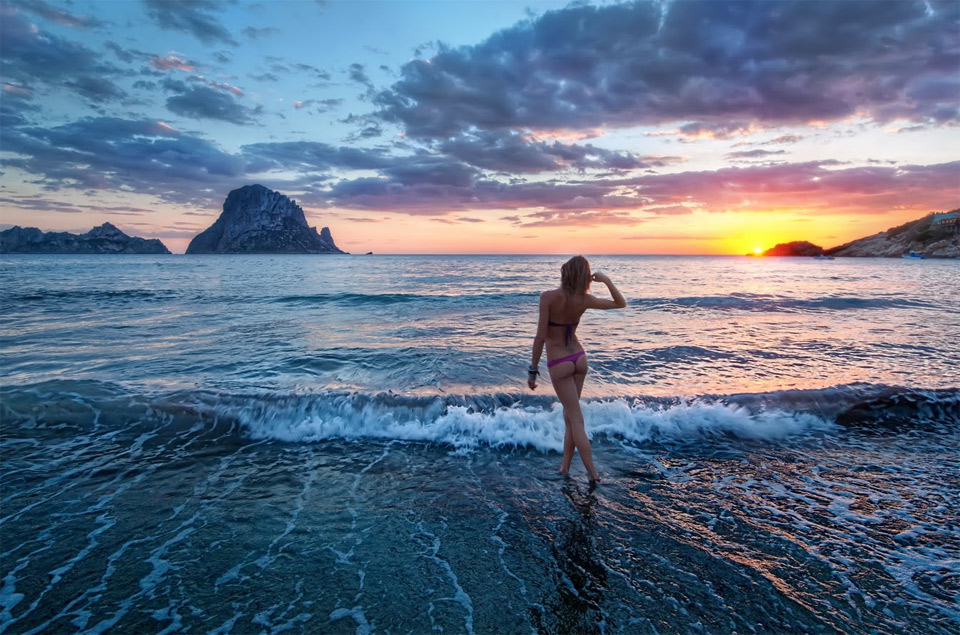

I see a man is riding a surfboard on a wave


In [116]:
def generate_caption(x1):
  
  caption = "startseq"
          
  for i in range(MAX_LEN):
    
    seq = tokenizer.texts_to_sequences([caption])
        
    x2 = pad_sequences(seq, maxlen=MAX_LEN)
        
    y = caption_model.predict([x1,x2], verbose=0)
    word = tokenizer.index_word[np.argmax(y)]
        
    caption+=" "+word
    
    if word == "endseq":
      break

  return caption


def caption_it(img):
  
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)  
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img, axis=0)
    
  x1 = encode_model.predict(img)
  x1 = x1.reshape((1, OUTPUT_DIM))
      
  caption = generate_caption(x1)
  
  return " ".join(caption.split()[1:-1])


img = Image.open("cat-2083492_960_720.jpg")

caption = caption_it(img)
display(img)
print("I see "+caption)

## Resources
* https://www.tensorflow.org/beta/tutorials/text/image_captioning
* https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
* https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb
* https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb